## Oscillating Chemical Reactions (Newman 8.18)
Belousov-Zhabotinsky Reaction: mixture of chemicals undergoes a series of reactions when heated, which causes the chemical concentrations to oscillate between two extremes. e.g. https://youtu.be/jRQAndvF4sM 

Here's a simplified description, where $x$ and $y$ are concentrations of two chemicals in the mixture ($a$ and $b$ are positive constants):
$$\frac{dx}{dt} = 1 - (b+1)x + ax^2y $$
$$\frac{dy}{dt} = bx - ax^2y$$

Write a program to solve this pair of ODEs using adaptive Bulirsch-Stoer, for the case of:
 * $a=1, b=3$
 * initial conditions $x = y =0$
 * time domain $t$ = 0 to 20
 * accuracy at least $\delta = 10^{-10}$ per unit time, in both $x$ and $y$
 * initially using single time interval $H=20$; allow maximum of $n=8$ MMP steps per interval before dividing the interval in half and trying again

### Implementation notes

Newman's bulirsch.py is useful as a starting point. 

One way to simplify the problem is to modify the code to use recursion. Write a user–defined function, e.g. step(r, t, H), that takes as arguments the vector $\mathbf{r} = (\mathbf{x},\mathbf{y})$ at time $t$ with an interval length $H$ and returns the vector at time $t + H$. This function should use the MMP until the calculation converges to the desired accuracy or you exceed a threshold for the number of steps. If you exceed the number of steps you should break the problem into smaller steps H/2 and try again with two calculations:

r1 = step(r, t, H/2)

r2 = step(r1, t+H/2, H/2)

Correctly written, this function will call itself to sub–divide the domain as needed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


def fct(r):
    """ RHS of ODE: a and b constants, r is vector (x,y) """
    x = r[0]
    y = r[1]
    fx = 1.0 - (b+1)*x + a*x*x*y
    fy = b*x - a*x*x*y
    return np.array([fx, fy], float)

In [5]:
def step(r, t, H, delta, nmax):
    """ adaptive Bulirsch-Stoer integration: r is vector (x,y), H big time interval, delta and nmax for convergence"""
    # Do one modified midpoint step to get things started
    r1 = r + 0.5*H*fct(r)
    r2 = r + H*fct(r1)

    R1 = np.empty([1, 2], float)
    R1[0] = 0.5*(r1 + r2 + 0.5*H*fct(r2))

    # Now increase n until the required accuracy is reached
    for n in range(2, nmax+1):
        h = H/float(n)
        r1 = r + 0.5*h*fct(r)  # MMP
        r2 = r + h*fct(r1)
        for i in range(n-1):
            r1 += h*fct(r2)
            r2 += h*fct(r1)

        # Calculate extrapolation estimates.  Arrays R1 and R2
        # hold the two most recent lines of the table
        R2 = R1
        R1 = np.empty([n, 2], float)
        R1[0] = 0.5*(r1 + r2 + 0.5*h*fct(r2))
        for m in range(1, n):
            epsilon = (R1[m-1]-R2[m-1])/((float(n)/float(n-1))**(2*m)-1)
            R1[m] = R1[m-1] + epsilon
        error = abs(epsilon[0])

        if error < H*delta:  # Check for convergence
            result = R1[n-1]
            tpoints.append(t+H)
            xpoints.append(result[0])
            ypoints.append(result[1])
            return result # base case of recursion

    # If convergence failed, do it again recursively, with smaller steps
    r1 = step(r, t, H/2, delta, nmax)
    r2 = step(r1, t+H/2, H/2, delta, nmax)

    return r2

In [6]:
# Main program ---------------------------------------------------------------|

a = 1.0  # constant for ODE
b = 3.0  # constant for ODE
tinit = 0.0  # initial time
tend = 20.0  # final time = size of big step
x0 = 0.0  # initial conditions
y0 = 0.0  # initial conditions
r = np.array([x0, y0], float)

# initialize lists
tpoints = []
xpoints = []
ypoints = []

step(r, tinit, tend, 1e-10, 8)

/tmp/ipykernel_102/2174555813.py:10: RuntimeWarning: overflow encountered in double_scalars
  fx = 1.0 - (b+1)*x + a*x*x*y
/tmp/ipykernel_102/2174555813.py:11: RuntimeWarning: overflow encountered in double_scalars
  fy = b*x - a*x*x*y
/tmp/ipykernel_102/3394179671.py:23: RuntimeWarning: invalid value encountered in add
  R1[0] = 0.5*(r1 + r2 + 0.5*h*fct(r2))
/tmp/ipykernel_102/3394179671.py:25: RuntimeWarning: invalid value encountered in subtract
  epsilon = (R1[m-1]-R2[m-1])/((float(n)/float(n-1))**(2*m)-1)


array([0.37510361, 3.72791584])

Make a plot of your solutions for $x$ and $y$, both on the same graph. Add dots to the curves to show where the boundaries of the time intervals lie; you should find the dots are closer together in parts of the solution where the variables are changing more rapidly.

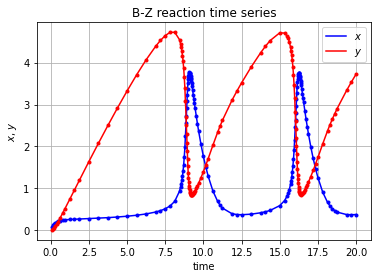

In [7]:
# Plot the results -----------------------------------------------------------|
plt.plot(tpoints, xpoints, "b-", label="$x$")
plt.plot(tpoints, xpoints, "b.")

plt.plot(tpoints, ypoints, "r-", label="$y$")
plt.plot(tpoints, ypoints, "r.")
plt.legend()
plt.xlabel("time")
plt.ylabel("$x$, $y$")
plt.title("B-Z reaction time series")
plt.grid()
plt.show()

## More Quantum Oscillators (Newman 8.14)

### Harmonic: Energies
Consider 1-D time-independent Schrodinger equation
$$ -\frac{\hbar^2}{2m}\frac{d^2 \psi}{dx^2}+V(x)\psi(x)=E\psi(x) $$
in harmonic potential:
$$V(x) = V_0 x^2 / a^2$$
with $V_0,~a$ constants. Convert to a pair of two first-order ODEs:
$$ \frac{d \psi}{d x} = \phi(x)$$
$$ \frac{d \phi}{d x} = \frac{2m}{\hbar^2}\left[V(x) - E\right] \psi(x) $$

Find the energies of the ground state and the first two excitated states, with:
 * $m$ = electron mass
 * $V_0$ = 50 eV
 * $a = 10^{-11}$ m
 * $x = -10a$ to $10a$, with $\psi = 0$ at both boundaries (instead of $x$ extending out to positive and negative infinity) 
 * evenly spaced points for the solution (no adaptive method)

Note the wavefunction is real everywhere, so no need for complex variables.

In [8]:
from scipy.integrate import simps
import scipy.constants as sc

def V(dist, order):
    """ Potential function; dist is x/a, order is
    the order of the polynomial (2 for harmonic, etc)"""
    V0 = 50.*sc.e  # [J] Potential at |x|=a
    return V0*dist**order


def f(r, dist, order, E):
    """ The RHSs of each 1st-order equations
    r is [psi, phi] at the last point, dist is distance from middle (x/a),
    order is order of potential (2 for harmonic, etc), E is energy level """
    psi = r[0]
    phi = r[1]
    fpsi = phi
    fphi = (2*sc.m_e/sc.hbar**2) * (V(dist, order)-E) * psi
    return np.array([fpsi, fphi], float)

In [9]:
def solve(E, order, xarray, a):
    """ Calculate the wavefunction for a particular energy using RK4
    xarray is are the distance from origin, a is the typical distance """
    psi = 0.0  # initial psi
    phi = 1.0  # initial phi = dpsi/dx
    r = np.array([psi, phi])
    psiarray = np.empty(len(xarray))
    dx = xarray[1] - xarray[0]

    for ii, xx in enumerate(xarray):
        k1 = dx*f(r, xx/a, order, E)
        k2 = dx*f(r+0.5*k1, (xx+0.5*dx)/a, order, E)
        k3 = dx*f(r+0.5*k2, (xx+0.5*dx)/a, order, E)
        k4 = dx*f(r+k3, (xx+dx)/a, order, E)
        r += (k1 + 2*k2 + 2*k3 + k4)/6
        psiarray[ii] = r[0]

    return psiarray

In [40]:
aB = 1e-11  # the typical distance
N = 1000
hwidth = 10*aB  # half-width of domain
N_lev = 3  # number of energy levels
target = sc.e*1e-7  # energy error target in eV
xarr = np.linspace(-hwidth, hwidth, N)
dx = (xarr[-1] - xarr[0])/(N-1)

In [41]:
nn = 2  # harmonic oscillator has degree 2

# reasonable bounds we expect the solution to fall within
# [minE0, maxE0, minE1, maxE1, minE2, maxE2]
E_bounds = np.array([100*sc.e, 200*sc.e, 400*sc.e, 500*sc.e, 600*sc.e, 700*sc.e])

In [66]:
# SOLVER CELL
psiarr = np.empty((N_lev, len(xarr)), dtype=float)

Energies = np.empty(N_lev, dtype=float)
for n in range(N_lev):
    E1 = E_bounds[n*2]
    E2 = E_bounds[n*2+1]
    
    psi2 = solve(E1, nn, xarr, aB)
            
    while abs(E1-E2) > target:
        psi1, psi2 = psi2, solve(E2, nn, xarr, aB)
        psi1b, psi2b = psi1[-1], psi2[-1]  # values at the end boundary
        E1, E2 = E2, E2 - psi2b*(E2-E1)/(psi2b - psi1b)  # secant method

    Energies[n] = E2  # in eV directly because V0 = 50.
    print("n = {0}, E = {1:.4f} eV".format(n, E2/sc.e))
    psiarr[n,:] = psi2[:]

n = 0, E = 205.3018 eV
n = 1, E = 735.6731 eV
n = 2, E = 1443.5337 eV


Note for the quantum harmonic oscillator: the energy states are evenly-spaced (276.0428 eV apart) as expected !

n = 0, E = 138.0214 eV

n = 1, E = 414.0642 eV

n = 2, E = 690.1071 eV

### Harmonic: Wavefunctions
Now calculate the properly-normalized wavefunctions of the harmonic oscillator for the three states. Make a plot of them, all on the same axis, as a function of $x$ from $-5a$ to $5a$.

Overlay with the exact solutions at http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/hosc5.html.

In [60]:
def normlztn(func, x):
    """ we only normalize for the 1st half because function is symmetric, then double the integral """
    nx = len(x)
    return (2*simps(abs(func[:nx//2])**2, x[:nx//2]))**.5

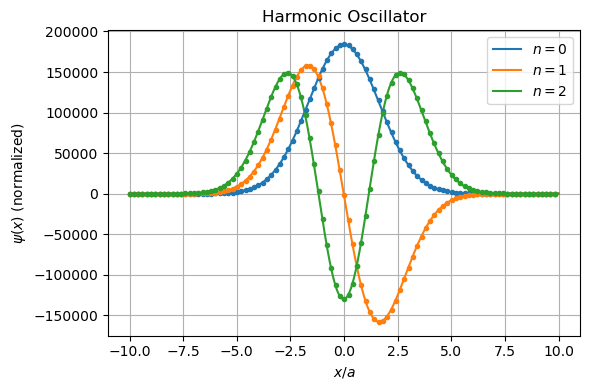

In [62]:
plt.figure(dpi=100)

# our numerical solutions
for n in range(N_lev):
    I_psi = normlztn(psiarr[n,:], xarr)
    plt.plot(xarr/aB, psiarr[n,:]/I_psi, label='$n={0}$'.format(n))
    
# analytical solutions from website
omega = (2*50*sc.e/sc.m_e)**.5/aB
alpha = sc.m_e*omega/sc.hbar
yarr = alpha**.5*xarr
psia0 = (alpha/sc.pi)**.25 * np.exp(-0.5*yarr**2)  
psia1 = -(4*alpha/sc.pi)**.25 * yarr * np.exp(-0.5*yarr**2)  
psia2 = (alpha/sc.pi/4)**.25 * (2*yarr**2 - 1) * np.exp(-0.5*yarr**2)
# plot every 10 points only
skip=10
plt.plot(xarr[::skip]/aB, psia0[::skip], '.', color='C0')
plt.plot(xarr[::skip]/aB, psia1[::skip], '.', color='C1')
plt.plot(xarr[::skip]/aB, psia2[::skip], '.', color='C2')

plt.grid()
plt.legend()
plt.xlabel('$x/a$')
plt.ylabel(r'$\psi(x)$ (normalized)')
#plt.xlim(-5, 5)
#plt.ylim(-2.2e5, 2.2e5)
plt.title("Harmonic Oscillator")
plt.tight_layout()
plt.show()

### Anharmonic: Energies
Now calculate the energies of the same 3 states for the anharmonic oscillator with the same parameter values:
$$ V(x) = V_0 x^4/a^4 $$

In [65]:
nn = 4  # anharmonic oscillator has degree4
E_bounds = np.array([100*sc.e, 200*sc.e, 500*sc.e, 700*sc.e, 1000*sc.e, 1200*sc.e])

# now re-run SOLVER CELL...

n = 0, E = 205.3018 eV

n = 1, E = 735.6731 eV

n = 2, E = 1443.5337 eV

### Anharmonic: Wavefunctions
Now calculate the properly-normalized wavefunctions of the anharmonic oscillator for the three states. Make a plot of them, all on the same axis, as a funcion of $x$ from $-5a$ to $5a$.

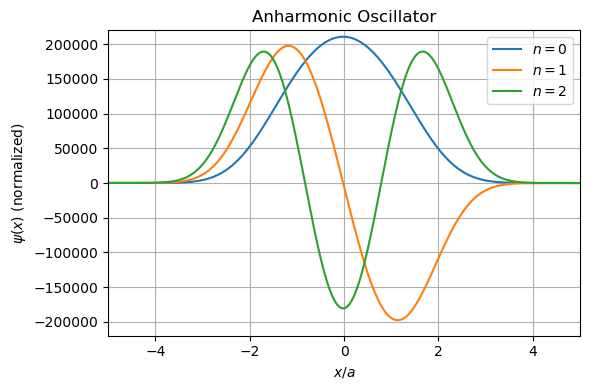

In [68]:
plt.figure(dpi=100)
for n in range(N_lev):
    I_psi = normlztn(psiarr[n,:], xarr)
    plt.plot(xarr/aB, psiarr[n,:]/I_psi, label='$n={0}$'.format(n))
plt.grid()
plt.legend()
plt.xlabel('$x/a$')
plt.ylabel(r'$\psi(x)$ (normalized)')
# need the limits to avoid numerical instabilities showing up
plt.xlim(-5, 5)
plt.ylim(-2.2e5, 2.2e5)

plt.title("Anharmonic Oscillator")
plt.tight_layout()
plt.show()
